# Google Colab Pro T4で実施しました

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR,SVR
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor,GradientBoostingRegressor,VotingRegressor,StackingRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from copy import deepcopy
from sklearn.inspection import permutation_importance
import pickle
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.base import BaseEstimator, RegressorMixin
warnings.filterwarnings('ignore')

In [2]:
SEED=42

# Set random seeds for reproducibility
def set_seed(seed=SEED):
    """Set random seeds for reproducibility."""
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed()

In [3]:
DIR = '.'

In [4]:
def one_hot_encoder(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype == 'category':
      one_hot = pd.get_dummies(df[col], prefix=f'{col}_', dtype=int)
      df = df.drop(col, axis=1)
      df = df.join(one_hot)
  return df

def generate_hour_one_hot(df):
  one_hot = pd.get_dummies(df['hour'].astype(str), prefix='hour_', dtype=int)
  df = df.drop('hour', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofweek_one_hot(df):
  one_hot = pd.get_dummies(df['dayofweek'].astype(str), prefix='dayofweek_', dtype=int)
  df = df.drop('dayofweek', axis=1)
  df = df.join(one_hot)
  return df

def generate_dayofyear_one_hot(df):
  one_hot = pd.get_dummies(df['dayofyear'].clip(upper=365).astype(str), prefix='dayofyear_', dtype=int)
  df = df.drop('dayofyear', axis=1)
  df = df.join(one_hot)
  return df

def setup_time(df):
  """
  setup time(utc=True) values to dataframe index.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: time indexed dataframe.
  """
  df['time'] = pd.to_datetime(df['time'], utc=True)
  df.set_index('time', inplace=True)
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  return df

def setup_dataframe(file):
  """
  setup dataframe.

  Args:
      file: csv file.

  Returns:
      pd.DataFrame: dataframe.
  """
  df = pd.read_csv(os.path.join(DIR, file))
  df = setup_time(df)

  df['valencia_temp_diff'] = df['valencia_temp_max'] - df['valencia_temp_min']

  non_fossil_sum_cols = [col for col in df.columns if col.startswith('generation') and col.find('fossil')<0]
  df['demand_non_fossil_diff']= df['total_load_actual'] - df[non_fossil_sum_cols].apply(np.sum, axis=1)

  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)
  df = one_hot_encoder(df)
  return df.fillna(0)

def one_hot_times(df):
  """
  one hot encoder.

  Args:
      df (pd.DataFrame): source dataframe.

  Returns:
      pd.DataFrame: The one hot encoded dataframe.
  """
  df = generate_hour_one_hot(df)
  df = generate_dayofweek_one_hot(df)
  df = generate_dayofyear_one_hot(df)
  return df

In [5]:
# prompt: 引数のdataframe(indexにdatetimeが設置済)にhour, dayofweek, dayofyearを追加、ただしdayofyearの上限は365

def add_time_features(df):
  """
  Add hour, dayofweek, and dayofyear features to a dataframe with a DatetimeIndex.

  Args:
      df (pd.DataFrame): The source dataframe with a DatetimeIndex.

  Returns:
      pd.DataFrame: The dataframe with added time features.
  """
  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['dayofyear'] = df.index.dayofyear
  #df = generate_hour_one_hot(df)
  #df = generate_dayofweek_one_hot(df)
  #df = generate_dayofyear_one_hot(df)

  return df

#HOUR_COLUMNS = [f'hour__{hour}' for hour in range(24)]
#DAYOFWEEK_COLUMNS = [f'dayofweek__{dayofweek}' for dayofweek in range(7)]
#DAYOFYEAR_COLUMNS = [f'dayofyear__{dayofyear}' for dayofyear in range(1,366)]

In [6]:
train_df = setup_dataframe('train.csv')
test_df = setup_dataframe('test.csv')

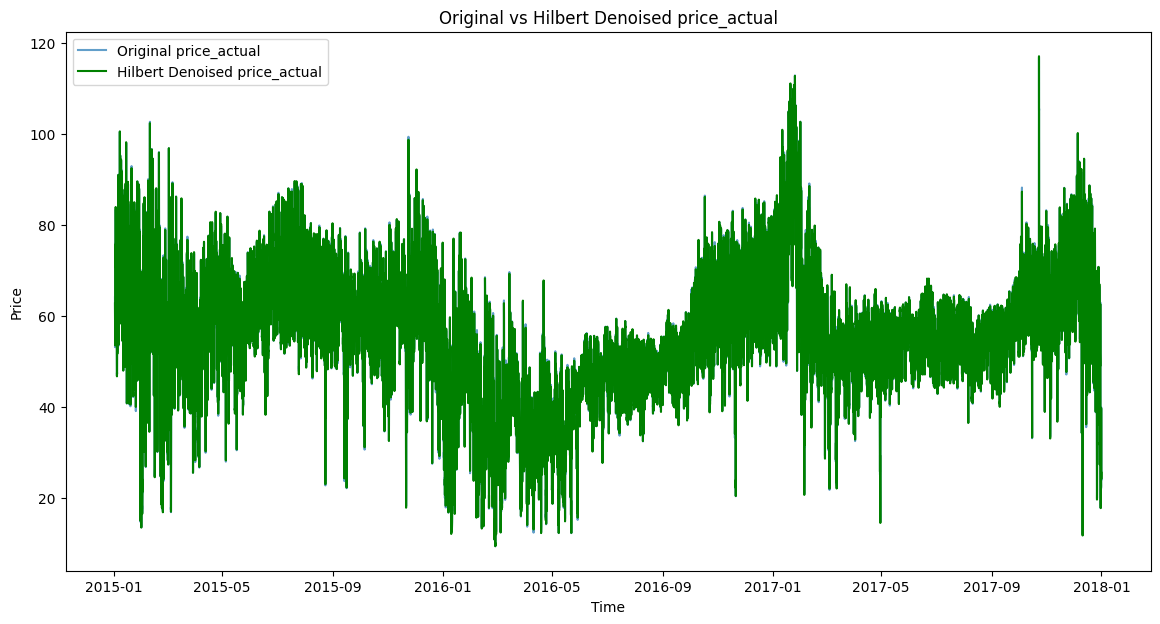

RMSE (Original vs Hilbert Denoised): 0.3255
R2 Score (Original vs Hilbert Denoised): 0.9995


In [7]:
# prompt: price_actualをヒルベルト変換でノイズ成分を除去
# 閾値は変数で定義

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert

def denoise_hilbert(data, threshold_percentage=5):
  """
  Denoises a time series using the Hilbert transform by removing components
  below a certain magnitude threshold in the frequency domain.

  Args:
      data (np.ndarray or pd.Series): The input time series data.
      threshold_percentage (float): The percentage of the maximum amplitude
                                    below which components will be zeroed out.

  Returns:
      np.ndarray: The denoised time series.
  """
  # Ensure data is a numpy array
  if isinstance(data, pd.Series):
    data_array = data.values
  else:
    data_array = np.asarray(data)

  # Compute the analytic signal using the Hilbert transform
  analytic_signal = hilbert(data_array)
  amplitude_envelope = np.abs(analytic_signal)

  # Compute the Fourier Transform
  fft_data = np.fft.fft(data_array)
  frequencies = np.fft.fftfreq(len(data_array))

  # Define the magnitude threshold based on a percentage of the maximum amplitude
  magnitude_threshold = np.max(np.abs(fft_data)) * (threshold_percentage / 100.0)

  # Create a mask for frequencies to keep (magnitudes above the threshold)
  fft_denoised = fft_data.copy()
  fft_denoised[np.abs(fft_data) < magnitude_threshold] = 0

  # Compute the inverse Fourier Transform to get the denoised signal
  denoised_data = np.fft.ifft(fft_denoised).real # Take the real part as the original signal was real

  return denoised_data

# Define the threshold percentage for Hilbert denoising
HILBERT_THRESHOLD_PERCENTAGE = 0.01 # Adjust this value as needed

# Apply Hilbert denoising to 'price_actual'
# Note: Hilbert transform is typically used for analyzing instantaneous frequency/amplitude
# and might not be the standard approach for general signal denoising compared to wavelet or Fourier methods.
# However, based on the request, we implement it this way.
# A more common approach for denoising with Fourier is simply zeroing out high frequencies.
# Let's apply it to train_df['price_actual']
train_df['price_actual_hilbert_denoised'] = denoise_hilbert(train_df['price_actual'], threshold_percentage=HILBERT_THRESHOLD_PERCENTAGE)

# Visualize the original and Hilbert denoised 'price_actual'
plt.figure(figsize=(14, 7))
plt.plot(train_df.index, train_df['price_actual'], label='Original price_actual', alpha=0.7)
plt.plot(train_df.index, train_df['price_actual_hilbert_denoised'], label='Hilbert Denoised price_actual', color='green')
plt.title('Original vs Hilbert Denoised price_actual')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate the difference between original and Hilbert denoised signal
rmse_hilbert = root_mean_squared_error(train_df['price_actual'], train_df['price_actual_hilbert_denoised'])
r2_hilbert = r2_score(train_df['price_actual'], train_df['price_actual_hilbert_denoised'])

print(f"RMSE (Original vs Hilbert Denoised): {rmse_hilbert:.4f}")
print(f"R2 Score (Original vs Hilbert Denoised): {r2_hilbert:.4f}")


In [8]:
# prompt: train_dfの数値項目を対象に年,月ごとのprice_actualとの相関係数(spearman)のデータフレームを作成

train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'price_actual', 'year', and 'month' from the numeric columns for correlation calculation against 'price_actual'
numeric_cols_for_corr = [col for col in numeric_cols if col not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', ]]

# Create an empty dictionary to store the correlation dataframes
monthly_yearly_correlations = {}

# Iterate through each numeric column (excluding 'price_actual', 'year', 'month')
for col in numeric_cols_for_corr:
    # Calculate the Spearman correlation for each year and month
    corr_df = train_df.groupby(['year', 'month'])[[col, 'price_actual']].corr(method='spearman').unstack().iloc[:, 1].unstack()
    monthly_yearly_correlations[col] = corr_df

# Combine the correlation dataframes into a single dataframe
# This will be a MultiIndex dataframe where the outer index is the column name
# and the inner index is the year and month
correlation_summary_df = pd.concat(monthly_yearly_correlations, axis=0)

# Display the resulting dataframe
correlation_summary_df.fillna(0, inplace=True)
correlation_summary_df_abs = correlation_summary_df.abs()

corr_mean_val = correlation_summary_df_abs.mean()
corr_std_val = correlation_summary_df_abs.std(ddof=0)

# Calculate the threshold: mean + 2 * std
target_threshold_std = corr_mean_val + 2 * corr_std_val

# Identify data points where the absolute correlation is greater than the threshold in any month
# We use .stack() to make it easier to filter based on values
anomalous_correlations = correlation_summary_df_abs[correlation_summary_df_abs > target_threshold_std].stack().reset_index()

print("Data points where absolute correlation is greater than mean + 2 * std in any month:")
FEATURES = anomalous_correlations['level_0'].unique()
FEATURES = [column for column in FEATURES if column not in ['price_actual', 'year', 'month', 'hour', 'dayofyear', 'dayofweek', 'price_actual_hilbert_denoised']]
#FEATURES
#

Data points where absolute correlation is greater than mean + 2 * std in any month:


In [9]:
WINDOW_SIZE=24*7*2
BATCH_SIZE=360
EPOCHS=20

In [10]:
def generate_labels(y, window_size):
  """
    generate labels.

    Args:
        y (pd.Series): target variable.
        window_size (int): window size.

    Returns:
        pd.DataFrame: labels.
  """
  labels = []
  indexes = []
  for i in range(len(y) - window_size + 1):
    window = y.iloc[i:i+window_size]
    indexes.append(window.index[-1])
    y_last = np.float32(window.iloc[-1])
    y_scale = np.float32(y_last/ window.mean())
    y_mean = np.float32(window.mean())
    y_median = np.float32(window.quantile(0.5))
    y_std = np.float32(window.std())
    y_zscore = np.float32((y_last - y_mean) / y_std)
    y_q25 = np.float32(window.quantile(0.25))
    y_q75 = np.float32(window.quantile(0.75))
    labels.append([y_last, y_scale, y_mean, y_median, y_std, y_zscore, y_q25, y_q75])
  return pd.DataFrame(labels, index=indexes).astype(np.float32)

In [11]:
# Define the LSTM model

# Custom Dataset for time series
class TimeSeriesDataset(Dataset):
    """Custom Dataset for time series data."""
    def __init__(self, X, y, sequence_length=WINDOW_SIZE,X_scaler=MinMaxScaler(), y_scaler=MinMaxScaler()):
        """
        Initializes the TimeSeriesDataset.

        Args:
            X (pandas,DataFrame): The input features.
            y (pandas.Series): The target variable.
            sequence_length (int): The length of the input sequence.
        """
        self.X = X
        self.y = y
        self.sequence_length = sequence_length
        self.X_scaler = X_scaler
        try:
          check_is_fitted(self.X_scaler)
        except NotFittedError as e:
          self.X_scaler.fit(self.X)
        if y is not None:
          self.y_scaler = y_scaler
          try:
            check_is_fitted(self.y_scaler)
          except NotFittedError as e:
            self.y_scaler.fit(self.y)

    def __len__(self):
        """Returns the total number of samples."""
        return len(self.X) - self.sequence_length + 1

    def __getitem__(self, index):
        """
        Gets a sample from the dataset.

        Args:
            index (int): The index of the sample.

        Returns:
            tuple: A tuple containing the input sequence and the target value.
        """
        X = self.X.iloc[index:index+self.sequence_length]
        y = self.y.iloc[index]
        #if 'dayofweek' in X.columns:
        #  X['dayofweek'] = X['dayofweek'].iloc[-1]
        #if 'hour' in X.columns:
        #  X['hour'] = X['hour'].iloc[-1]
        X = self.X_scaler.transform(X).astype(np.float32)
        if self.y is not None:
          y = self.y_scaler.transform([y]).astype(np.float32)

        return torch.tensor(X), torch.tensor(y[0]) if self.y is not None else torch.tensor(X)


In [12]:
# prompt: pytorchのLSTMモデル
# バッチサイズ : 360
# sequence_size : 24 * 7 * 2
# GPUが使える場合はGPU
# 正解labelは y_の最後の要素, yの平均のタプル
# モデルを定義して学習、予測のsample

import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.exceptions import NotFittedError
from tqdm import tqdm

# Define the LSTM model
class LSTMModel(nn.Module):
    """LSTM model for time series forecasting."""
    def __init__(self, input_size, hidden_layer_size, output_size):
        """
        Initializes the LSTM model.

        Args:
            input_size (int): The number of input features.
            hidden_layer_size (int): The size of the hidden layer in the LSTM.
            output_size (int): The size of the output (number of predicted steps).
        """
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        # Use batch_first=True for batch size to be the first dimension
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)


    def forward(self, input_seq):
        """
        Performs a forward pass through the model.

        Args:
            input_seq (torch.Tensor): The input sequence with shape (batch_size, sequence_length, input_size).

        Returns:
            torch.Tensor: The output prediction with shape (batch_size, output_size).
        """
        # input_seq shape is (batch_size, sequence_length, input_size)
        lstm_out, _ = self.lstm(input_seq) # LSTM output shape is (batch_size, sequence_length, hidden_size)

        # We are interested in the output of the last time step
        last_time_step_output = lstm_out[:, -1, :] # Shape is (batch_size, hidden_size)

        predictions = self.linear(last_time_step_output) # Shape is (batch_size, output_size)
        return predictions

class LSTMRegressor(BaseEstimator, RegressorMixin):
    """
    A scikit-learn compatible regressor using an LSTM model.
    """
    def __init__(self, hidden_layer_size=50, learning_rate=0.001, epochs=10, batch_size=50, sequence_length=100):
        """
        Initializes the LSTMRegressor.

        Args:
            hidden_layer_size (int): The size of the hidden layer in the LSTM.
            learning_rate (float): The learning rate for the optimizer.
            epochs (int): The number of training epochs.
            batch_size (int): The batch size for training.
            sequence_length (int): The length of the input sequence for the LSTM.
        """
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.X_scaler = MinMaxScaler()
        self.y_scaler = MinMaxScaler()


    def fit(self, X, y):
        """
        Fits the LSTM model to the training data.

        Args:
            X (pandas.DataFrame): The training input features.
            y (pandas.Series): The training target variable.

        Returns:
            LSTMRegressor: The fitted regressor instance.
        """
        #X, y = check_X_y(X, y, estimator=self, force_all_finite=True)
        model_loss_value = 1000

        # Store the feature names for later use in predict
        self.feature_names_in_ = X.columns.tolist()

        # Scale the data - fit on the entire training data
        self.X_scaler.fit(X)
        self.y_scaler.fit(y)

        # Create the dataset and dataloader
        train_dataset = TimeSeriesDataset(X, y, sequence_length=self.sequence_length,
                                           X_scaler=self.X_scaler, y_scaler=self.y_scaler)
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True) # drop_last to handle batches smaller than batch_size


        # Initialize the model, loss function, and optimizer
        INPUT_SIZE = X.shape[1]
        # Output size is 8 for scaled y_last and scaled y_mean
        OUTPUT_SIZE = 8
        self.model_ = LSTMModel(input_size=INPUT_SIZE ,
                                hidden_layer_size=self.hidden_layer_size,
                                output_size=OUTPUT_SIZE).to(device)

        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model_.parameters(), lr=self.learning_rate)

        # Training loop
        self.model_.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for i, (seq, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{self.epochs}")):
                # Move data to device
                seq = seq.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                outputs = self.model_(seq)

                # Calculate loss
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(train_loader)
            if avg_loss < model_loss_value:
                model_loss_value = avg_loss
                torch.save(self.model_.state_dict(), os.path.join(DIR,'best_model_v004.pth'))

            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")

        self.is_fitted_ = True
        torch.save(self.model_.state_dict(), os.path.join(DIR,'last_model_v004.pth'))
        return self

    def restore(self, model_file='best_model_v004.pth'):
        self.model_.load_state_dict(torch.load(os.path.join(DIR, model_file)))
        self.model_.eval()
        return self

    def predict(self, X):
        """
        Predicts target values using the fitted LSTM model.

        Args:
            X (pandas.DataFrame): The input features for prediction.

        Returns:
            numpy.ndarray: The predicted target values (inverse scaled).
        """
        check_is_fitted(self)
        #X = check_array(X, estimator=self, force_all_finite=True)

        # Ensure the columns match the training data
        if list(X.columns) != self.feature_names_in_:
             raise ValueError("Input features during predict do not match features seen during fit.")

        # Scale the data
        X_scaled = self.X_scaler.transform(X)

        # Create sequences for prediction
        predict_sequences = []
        # For prediction, we assume X contains the features up to the point of prediction.
        # We need the last `self.sequence_length` observations to predict the next value.
        # If X has length N, and sequence_length is L, we can make N - L + 1 predictions.
        # The prediction made from the sequence X[i:i+L] predicts the value *after* X[i+L-1].
        # So, the predictions will correspond to the original index from X.index[self.sequence_length - 1:]
        for i in range(len(X_scaled) - self.sequence_length + 1):
            predict_sequences.append(X_scaled[i:i+self.sequence_length])

        # If X is shorter than the sequence length, we cannot form any sequence
        if not predict_sequences:
             print("Warning: Input data length is less than sequence_length. No predictions can be made.")
             # If X is a pandas DataFrame, return an empty Series with the correct dtype
             if isinstance(X, pd.DataFrame):
                 # The output is a tuple (last_y, mean_y), so the Series should contain tuples
                 return pd.Series(dtype='object')
             else: # If X is a numpy array, return just an empty numpy array
                 return np.array([])


        # Create DataLoader for prediction. Use a batch size that is a multiple of the total prediction size
        # or set batch size to the total number of samples to process all at once.
        # Ensure drop_last=False for prediction to get all predictions.
        predict_dataset = torch.FloatTensor(np.array(predict_sequences))
        # Adjust batch size for prediction if the number of samples is not a multiple of training batch_size
        predict_batch_size = min(self.batch_size, len(predict_dataset))
        # If the number of samples is less than the training batch size, use the number of samples as batch size
        if len(predict_dataset) < self.batch_size:
             predict_batch_size = len(predict_dataset)
        # If len(predict_dataset) is 0, predict_batch_size would be 0, need to handle this
        if predict_batch_size == 0:
             print("Warning: No sequences can be formed for prediction.")
             if isinstance(X, pd.DataFrame):
                 return pd.Series(dtype='object')
             else:
                 return np.array([])


        predict_loader = DataLoader(predict_dataset, batch_size=predict_batch_size, shuffle=False, drop_last=False)


        self.model_.eval()
        with torch.no_grad():
            all_predictions = []
            for seq_batch in predict_loader:
                seq_batch = seq_batch.to(device)

                # No need to reset hidden state per batch if using batch_first=True and not stateful
                # The LSTM handles batches independently when batch_first=True

                outputs = self.model_(seq_batch)
                all_predictions.append(outputs.cpu().numpy())

        # Concatenate predictions from all batches
        predictions_scaled = np.concatenate(all_predictions, axis=0) # Shape (num_predictions, output_size)

        # Inverse transform the predictions for both y_last and y_mean
        # The inverse_transform expects shape (n_samples, n_features), so we need to apply it column-wise or reshape
        predictions_unscaled = self.y_scaler.inverse_transform(predictions_scaled)


        # The number of predictions is len(X) - sequence_length + 1.
        # These predictions correspond to the time indices from X.index[self.sequence_length - 1:]

        # Return predictions aligned with the correct part of the original index
        # The output is a tuple: (predicted_y_last, predicted_y_mean)

        y_0 = predictions_unscaled[:, 0]
        y_1 = predictions_unscaled[:, 1]
        y_2 = predictions_unscaled[:, 2]
        y_3 = predictions_unscaled[:, 3]
        y_4 = predictions_unscaled[:, 4]
        y_5 = predictions_unscaled[:, 5]
        y_6 = predictions_unscaled[:, 6]
        y_7 = predictions_unscaled[:, 7]

        # Combine the predictions into a list of tuples
        combined_predictions = list(zip(y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7))

        # If X is a pandas DataFrame, return a Series of tuples with the correct index
        if isinstance(X, pd.DataFrame):
            # The predictions correspond to the time steps *after* the end of the sequence
            # So, the prediction from sequence X[i:i+L] predicts the value at X.index[i+L]
            # However, the task description implies predicting the last element of y_ (price_actual)
            # and the mean of y_ within the sequence.
            # Let's re-read the requirement: "正解labelは y_の最後の要素, yの平均のタプル"
            # This means for a sequence X[i:i+L] (corresponding to y[i:i+L]), the model should predict
            # the tuple (y[i+L-1], mean(y[i:i+L])).
            # Therefore, the predictions correspond to the original index from X.index[self.sequence_length - 1:]
            return pd.Series(combined_predictions, index=X.index[self.sequence_length - 1:])
        else: # If X is a numpy array, return a numpy array of tuples
             # Note: numpy arrays are less suitable for storing tuples; a structured array or object array would be needed,
             # or simply return two separate arrays. Let's return an object array of tuples for simplicity.
             return np.array(combined_predictions, dtype='object')


# Example usage:
# Assuming X_train and y_train are your training data (pandas DataFrames/Series)
# and X_test is your test data (pandas DataFrame)

# Select features and target for LSTM
# Adjust FEATURES list as needed based on your data
# Ensure FEATURES list is defined before this block if it's not in the provided code
#if 'FEATURES' not in locals():
#    print("FEATURES list not found. Using all columns except 'price_actual'.")
#    FEATURES = [col for col in train_df.columns if col != 'price_actual' and train_df[col].dtype in [np.float32, np.float64, np.int64]]

X_train_lstm = train_df[FEATURES]
y_train_lstm = generate_labels(train_df['price_actual'], WINDOW_SIZE)
# For prediction, we need to form sequences from the available test data.
# If the test data starts *after* the training data ends, we need to include the last
# `sequence_length - 1` samples from the training data to form the first sequence for the test set.
# Let's assume X_test_lstm should be the test_df features, but we need to handle sequence creation.
# A common approach is to create a sequence from the last training data points + test data points.
# However, the predict method in the refactored class handles sequence creation internally.
# The input to predict should be the data for which you want to make predictions.
# If you want to predict for the entire test_df, pass test_df[FEATURES] to predict.
# The predict method will then create overlapping sequences of length sequence_length
# and make predictions for the last element of each sequence.
# The index of the predictions will start from the point where the first full sequence ends in the test_df.

# Example: Predicting for the entire test_df
# X_test_lstm = test_df[FEATURES] # Use test_df features directly

# If you want to predict the values *after* the training data ends,
# you need to append the test data to the training data for prediction sequence generation.
# However, the predict method in the refactored class works on a single input DataFrame.
# It predicts for the indices from `self.sequence_length - 1` onwards within the input DataFrame.
# So, to predict for test_df, pass test_df[FEATURES] to predict.

# Let's assume you want to predict for the test_df
X_test_lstm = pd.concat([X_train_lstm.iloc[ - WINDOW_SIZE + 1:] ,test_df])[FEATURES].fillna(0)


# Set the device for training and prediction
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds for reproducibility
set_seed()

# Initialize and fit the LSTM Regressor
# Adjust hidden_layer_size, learning_rate, epochs as needed
# Batch size and sequence length are parameters from the problem description
lstm_regressor = LSTMRegressor(hidden_layer_size=len(FEATURES), learning_rate=0.001, epochs=1,
                               batch_size=BATCH_SIZE, sequence_length=WINDOW_SIZE)

# Check if the number of training samples is sufficient for the given sequence length
if len(X_train_lstm) >= lstm_regressor.sequence_length:
    print("Fitting the LSTM model...")
    lstm_regressor.fit(X_train_lstm, y_train_lstm)

    # Predict on the test data
    # Check if the test data length is sufficient to form at least one sequence
    if len(X_test_lstm) >= lstm_regressor.sequence_length:
        print("Making predictions on the test data...")
        predictions = lstm_regressor.predict(X_test_lstm)
        print("Predictions (tuple of predicted_y_last, predicted_y_mean):")
        print(predictions)
    else:
        print(f"Test data length ({len(X_test_lstm)}) is less than sequence_length ({lstm_regressor.sequence_length}). Cannot make predictions.")

else:
    print(f"Training data length ({len(X_train_lstm)}) is less than sequence_length ({lstm_regressor.sequence_length}). Cannot fit the model.")




Using device: cuda:0
Fitting the LSTM model...


Epoch 1/1: 100%|██████████| 72/72 [01:00<00:00,  1.20it/s]


Epoch 1/1, Loss: 0.0468
Making predictions on the test data...
Predictions (tuple of predicted_y_last, predicted_y_mean):
time
2017-12-31 23:00:00+00:00    (46.08748, 0.8894946, 61.295322, 56.920765, 5....
2018-01-01 00:00:00+00:00    (44.823784, 0.89915746, 61.389717, 56.74981, 6...
2018-01-01 01:00:00+00:00    (45.44237, 0.8999072, 61.226692, 57.16657, 6.1...
2018-01-01 02:00:00+00:00    (45.84365, 0.89759237, 61.223186, 57.151894, 6...
2018-01-01 03:00:00+00:00    (46.56101, 0.8687434, 60.415043, 56.59536, 6.4...
                                                   ...                        
2018-12-31 18:00:00+00:00    (48.981388, 0.935818, 61.399395, 57.28916, 5.9...
2018-12-31 19:00:00+00:00    (47.5953, 0.92556685, 61.204056, 56.991283, 6....
2018-12-31 20:00:00+00:00    (47.630295, 0.9206746, 61.436512, 57.00262, 6....
2018-12-31 21:00:00+00:00    (47.44043, 0.917555, 61.456173, 56.928764, 6.2...
2018-12-31 22:00:00+00:00    (47.891743, 0.91597193, 61.28666, 56.961857, 6...
Leng

In [13]:
predictions.map(lambda x:x[0]).describe()

,0
count,8760.000000
mean,48.038525
std,1.960548
min,40.766582
25%,46.695231
50%,48.108000
75%,49.528446
max,53.722176


In [14]:
predictions.map(lambda x:x[-1]).describe()

,0
count,8760.000000
mean,64.078072
std,0.850238
min,61.461933
25%,63.477907
50%,64.096294
75%,64.690809
max,67.423698


In [15]:
set_seed()

EPOCHS=30
WINDOW_SIZE=24 * 7 * 2
BATCH_SIZE=360
hidden_layer_size=len(FEATURES)

X_test_lstm = pd.concat([X_train_lstm.iloc[ - WINDOW_SIZE + 1:] ,test_df],axis=0)[FEATURES].fillna(0)
y_train_lstm = generate_labels(train_df['price_actual_hilbert_denoised'], WINDOW_SIZE)

FEATURES_WITH_TIME = FEATURES + ['dayofyear', 'dayofweek', 'hour']

lstm_regressor = LSTMRegressor(hidden_layer_size=hidden_layer_size, learning_rate=0.001, epochs=EPOCHS,
                               batch_size=BATCH_SIZE, sequence_length=WINDOW_SIZE)
X = add_time_features(X_train_lstm[X_train_lstm.index <= '2015-08-31'].copy())[FEATURES_WITH_TIME]
y = y_train_lstm[y_train_lstm.index.isin(X.index)]
lstm_regressor.fit(X, y)
y_pred = lstm_regressor.restore().predict(add_time_features(X_test_lstm.copy())[FEATURES_WITH_TIME])
sample_submit = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'),header=None, names=['time','y_pred'])
sample_submit['y_pred'] = list(y_pred.map(lambda x:x[0]))
file = f'submit_lstm_{WINDOW_SIZE}_{BATCH_SIZE}_{EPOCHS}_{hidden_layer_size}_2_sigma_with_time_v004.csv'
print(file)
sample_submit.to_csv(os.path.join(DIR,file), index=False, header=None)
sample_submit.head(),sample_submit.describe()

Epoch 1/30: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 1/30, Loss: 0.1092


Epoch 2/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 2/30, Loss: 0.0895


Epoch 3/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 3/30, Loss: 0.0469


Epoch 4/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 4/30, Loss: 0.0425


Epoch 5/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 5/30, Loss: 0.0415


Epoch 6/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 6/30, Loss: 0.0377


Epoch 7/30: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 7/30, Loss: 0.0356


Epoch 8/30: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 8/30, Loss: 0.0327


Epoch 9/30: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 9/30, Loss: 0.0308


Epoch 10/30: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 10/30, Loss: 0.0291


Epoch 11/30: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 11/30, Loss: 0.0277


Epoch 12/30: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 12/30, Loss: 0.0266


Epoch 13/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 13/30, Loss: 0.0255


Epoch 14/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 14/30, Loss: 0.0239


Epoch 15/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 15/30, Loss: 0.0222


Epoch 16/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 16/30, Loss: 0.0210


Epoch 17/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 17/30, Loss: 0.0198


Epoch 18/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 18/30, Loss: 0.0181


Epoch 19/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 19/30, Loss: 0.0186


Epoch 20/30: 100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Epoch 20/30, Loss: 0.0212


Epoch 21/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 21/30, Loss: 0.0206


Epoch 22/30: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 22/30, Loss: 0.0180


Epoch 23/30: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 23/30, Loss: 0.0248


Epoch 24/30: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 24/30, Loss: 0.0356


Epoch 25/30: 100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Epoch 25/30, Loss: 0.0243


Epoch 26/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 26/30, Loss: 0.0208


Epoch 27/30: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 27/30, Loss: 0.0194


Epoch 28/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 28/30, Loss: 0.0201


Epoch 29/30: 100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Epoch 29/30, Loss: 0.0182


Epoch 30/30: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 30/30, Loss: 0.0171
submit_lstm_336_360_30_91_2_sigma_with_time_v004.csv


(                        time     y_pred
 0  2018-01-01 00:00:00+01:00  58.096313
 1  2018-01-01 01:00:00+01:00  53.565559
 2  2018-01-01 02:00:00+01:00  53.879761
 3  2018-01-01 03:00:00+01:00  52.887959
 4  2018-01-01 04:00:00+01:00  51.514076,
             y_pred
 count  8760.000000
 mean     65.630889
 std       7.508413
 min      37.929203
 25%      60.742952
 50%      65.997478
 75%      71.281200
 max      83.306915)

In [16]:
y_pred = lstm_regressor.restore('last_model_v004.pth').predict(add_time_features(X_test_lstm.copy())[FEATURES_WITH_TIME])
sample_submit = pd.read_csv(os.path.join(DIR, 'sample_submit.csv'),header=None, names=['time','y_pred'])
sample_submit['y_pred'] = list(y_pred.map(lambda x:x[0]))
file = f'submit_lstm_{WINDOW_SIZE}_{BATCH_SIZE}_{EPOCHS}_{hidden_layer_size}_last_model_2_sigma_with_time_v004.csv'
print(file)
sample_submit.to_csv(os.path.join(DIR,file), index=False, header=None)
sample_submit.head(),sample_submit.describe()

submit_lstm_336_360_30_91_last_model_2_sigma_with_time_v004.csv


(                        time     y_pred
 0  2018-01-01 00:00:00+01:00  58.096313
 1  2018-01-01 01:00:00+01:00  53.565559
 2  2018-01-01 02:00:00+01:00  53.879761
 3  2018-01-01 03:00:00+01:00  52.887959
 4  2018-01-01 04:00:00+01:00  51.514076,
             y_pred
 count  8760.000000
 mean     65.630889
 std       7.508413
 min      37.929203
 25%      60.742952
 50%      65.997478
 75%      71.281200
 max      83.306915)